# Question 2
This sections wants to answer the question:
> Are reviews more subjective for some categories of products than for others, based on sentiment analysis?

and give deeper insight into subjectivity concerning the reviews over all categories. For this reason this section covers loading, sampling and transforming data to further analys it and draw conclusions. 

- Use pre-existing sentiment analysis approaches (e.g. “TextBlob” package [2]).
- Compare the subjectiveness scores of different product categories.

- perform an sentiment analysis with textblob on subjectivity [1-subjectivity=objectivity]; This should be done for summary and reviewText.
- additionally we could compare it to the reviewTime; if this has an effect on it or not
- laslty it would be interesting if there is a correlation between subjectivity and votes; to see if people react on those
- check if polarity and reviewTime have an impact

## Imports
This section contains all the imports needed to execute all further cells.

In [7]:
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg
from pyspark.sql.types import StringType, DoubleType
from textblob import TextBlob

/home/maxkleinegger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-jFqIN7wz-py3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/19 18:58:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

In [7]:
data = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
print(data.shape)

(230139802, 25)


In [3]:
categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances', 'Arts_Crafts_and_Sewing', 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']

24/01/19 18:58:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
distribution_of_categories = data['category'].value_counts()

NameError: name 'data' is not defined

In [32]:
##
## Calulates the distribution of Star Ratings for each Category and picks equally sized samples for each Category, each following the aforementioned distribution
##

def sample_for_sentiment(file_name):
    mode = 'w'
    for category in categories:
        print(f"Currently subsampling category {category} ...")
        rows_for_category = ps.read_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin'])
        for stars in range(1, 6):
            rows_for_category_and_rating = rows_for_category[rows_for_category['overall'] == stars]
            if not rows_for_category_and_rating.empty:
                sampled_rows = rows_for_category_and_rating.sample(frac = 0.1, replace=False, random_state=42)
                sampled_rows.to_parquet(file_name, mode=mode, index_col=['reviewerID', 'asin'])
                mode = 'a'

sample_for_sentiment("/data/question2_1.parquet")

Currently subsampling category AMAZON_FASHION ...


Currently subsampling category All_Beauty ...
Currently subsampling category Appliances ...


Currently subsampling category Arts_Crafts_and_Sewing ...


Currently subsampling category Automotive ...


Currently subsampling category Books ...


ERROR:root:KeyboardInterrupt while sending command.              (86 + 8) / 203]
Traceback (most recent call last):
  File "/home/maxkleinegger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-jFqIN7wz-py3.11/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maxkleinegger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-jFqIN7wz-py3.11/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maxkleinegger/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [73]:
data = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
data = data.to_spark()
data = data.sample(withReplacement=False, fraction=0.001, seed=42)
print(data.count)
data = data.toPandas()

<bound method DataFrame.count of DataFrame[index: bigint, image: array<string>, overall: double, reviewText: string, reviewTime: string, reviewerName: string, style: struct<Color:string,Color Name:string,Design:string,Flavor:string,Format:string,Item Package Quantity:string,Package Quantity:string,Package Type:string,Pattern:string,Scent Name:string,Size:string,Size Name:string,Style:string,Style Name:string>, summary: string, unixReviewTime: bigint, verified: boolean, vote: string, also_buy: array<string>, also_view: array<string>, brand: string, date: string, description: array<string>, feature: array<string>, fit: string, imageURL: array<string>, imageURLHighRes: array<string>, price: string, rank: string, title: string, category: string, main_cat: string]>


In [ ]:
df2 = data.to_spark()
df2.to_parquet("/data/question2.parquet", index_col=['reviewerID', 'asin'])

In [5]:
df = ps.read_parquet(f'/data/question2.parquet', index_col=['reviewerID', 'asin'])
#print((df.count(), len(df.columns)))
display(df.head())
#test = ps.read_parquet(f'/data/{"Books"}.parquet', index_col=['reviewerID', 'asin'])
#print((test.count(), len(test.columns)))

NameError: name 'ps' is not defined

## Transform data
After loading and subsampling all the data necessary, we need to 

In [130]:
# cols [id, reviewerId, summary [polarity, subjectivity], reviewtext [polarity, subjectivity], vote, reviewerName, ]
def apply_sentiment_analysis(df):
    print(f"Number of rows with empty reviewText: {len(df[df['reviewText'].isna()])}")
    print(f"Number of rows with empty summary: {len(df[df['summary'].isna()])}")
    df = df[['category', 'overall', 'verified', "vote", 'summary', "reviewText", "reviewTime"]].dropna()  # Remove not needed rows and cols

    df = df.to_spark()

    calculate_subjectivity = udf(lambda x: TextBlob(x).subjectivity, DoubleType())
    # calculate_polarity = udf(lambda x: TextBlob(x).polarity, DoubleType())
    calculate_sentiment_subjectivity = udf(lambda compound: 'very_subjective' if compound >= 0.75 
                                else ('subjective' if compound > 0.5 
                                else ('very_objective' if compound < 0.25 
                                else ('objective' if compound < 0.5
                                else 'neutral'))), StringType())
    '''
    calculate_sentiment_polarity = udf(lambda compound: 'very_positive' if compound >= 0.75 
                                else ('positive' if compound >= 0.25 
                                else ('very_negative' if compound <= -0.75 
                                else ('negative' if compound <= -0.25
                                else 'neutral'))), StringType())
    '''
    df = df.withColumn("reviewText-subjectivity", calculate_subjectivity(df['reviewText']))
    # df = df.withColumn("reviewText-polarity", calculate_polarity(df['reviewText']))
    df = df.withColumn("summary-subjectivity", calculate_subjectivity(df['summary']))
    # df = df.withColumn("summary-polarity", calculate_polarity(df['summary']))

    df = df[['category', 'overall', 'verified', "vote", "reviewTime", 'reviewText-subjectivity', 'summary-subjectivity']] #'reviewText-polarity' 'summary-polarity'
    df = df.withColumn("reviewText-sentiment-subjectivity", calculate_sentiment_subjectivity(df['reviewText-subjectivity']))
    df = df.withColumn("summary-sentiment-subjectivity", calculate_sentiment_subjectivity(df['summary-subjectivity']))
    # df = df.withColumn("reviewText-sentiment-polarity", calculate_sentiment_polarity(df['reviewText-subjectivity']))
    # df = df.withColumn("summary-sentiment-polarity", calculate_sentiment_polarity(df['summary-subjectivity']))

    return df

data_sentiment = apply_sentiment_analysis(df)
data_sentiment.write.parquet("/data/question2_calc.parquet", mode="overwrite")

Number of rows with empty reviewText: 1523


/home/maxkleinegger/.cache/pypoetry/virtualenvs/tu-dopp-ws23-jFqIN7wz-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of rows with empty summary: 741


In [8]:
#test2 = ps.read_parquet(f'/data/{"question2_test3"}.parquet')
df = spark.read.parquet(f'/data/{"question2_calc"}.parquet')
df2 = df.groupBy("category", "reviewText-sentiment-subjectivity").agg(count("*").alias("count"))
df2_wide = df2.groupBy("category").pivot("reviewText-sentiment-subjectivity").sum("count")
df2_wide.fillna(0)

#calc_sum = udf(lambda x: x['very_subjective'] + x['subjective'] + x['neutral'] + x['objective'] + x['very_objective'], DoubleType())

df2_wide = df2_wide.withColumn("number_of_reviews", col("very_subjective") + col("subjective") + col("neutral") + col("objective") + col("very_objective"))

df_average = df.groupBy("category").agg(avg("reviewText-subjectivity").alias("average_subjectivity"))
df2_wide = df2_wide.join(df_average, "category", "inner")
df2_wide.show()


+--------------------+-------+---------+----------+--------------+---------------+-----------------+--------------------+
|            category|neutral|objective|subjective|very_objective|very_subjective|number_of_reviews|average_subjectivity|
+--------------------+-------+---------+----------+--------------+---------------+-----------------+--------------------+
|Cell_Phones_and_A...|    109|     2328|      3462|           384|            670|             6953|  0.5293394429527929|
|      Toys_and_Games|    152|     3476|      4608|           438|            930|             9604|  0.5309686313214693|
|         Video_Games|     38|     2032|      2127|           125|            159|             4481|  0.5041020821553867|
|        Kindle_Store|     83|     2647|      4023|           221|            421|             7395|   0.529692317382178|
|        Prime_Pantry|     10|      138|       223|            35|             53|              459|  0.5272632617811864|
|          All_Beauty|  

## Analyse data
In this section, we want to analyse the data and therefore try to answer the question and dig deeper into the subjectivity of amazon reviews. To answer our question we start by observing a potential difference between the subjectivity of the reviewtext and the summary.

### Review text
First we analyse the distribution of our subjectivity metric across all different categories. The plot below show them. We can see that mostly all categories follow a normal distribution which peaks at the ends, which indicates the amount of very objective and very subjective reviews. If you look at the category `Gift_Cards` you see that those contain a big percentage of objective reviews in comparison to all other categories.

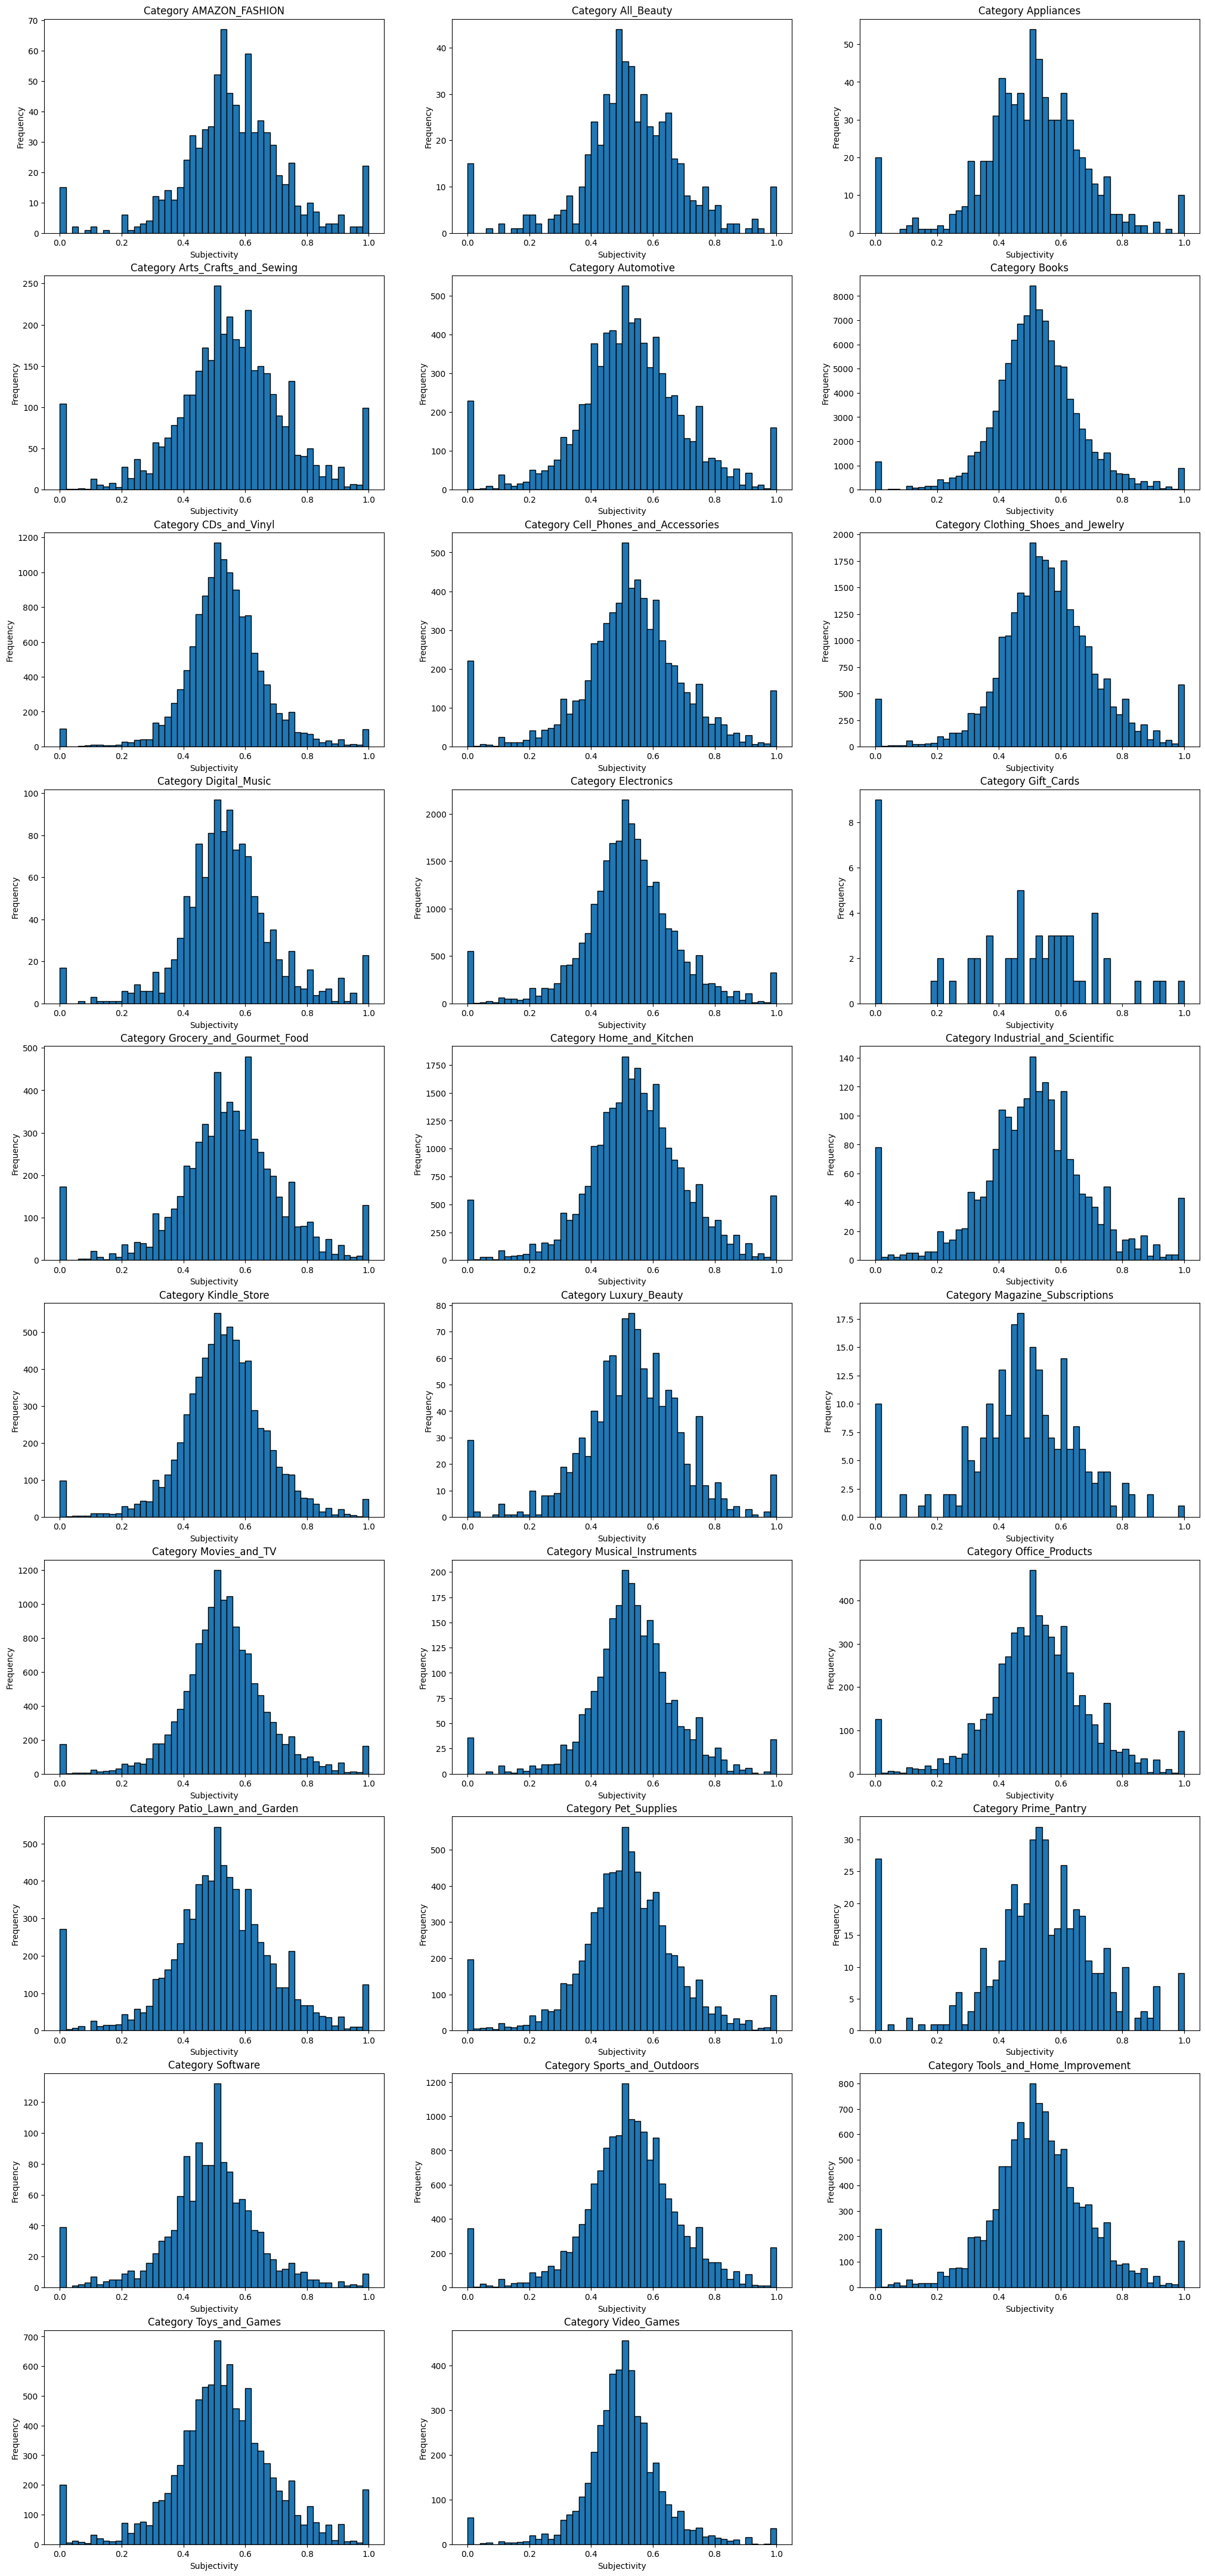

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(categories)//3+1, 3, figsize=(25, 55))
axes = axes.flatten()

for i, category in enumerate(categories):
    dist = df.filter(df.category == category).select("reviewText-subjectivity").rdd.flatMap(lambda x: x).collect()

    # Plot a histogram using matplotlib
    axes[i].hist(dist, bins=50, edgecolor='black')
    axes[i].set_title(f'Category {category}')
    # Customize the plot
    
    axes[i].set_xlabel('Subjectivity')
    axes[i].set_ylabel('Frequency')

fig.delaxes(axes[-1])
plt.show()

In [12]:
dist = df.select("category", "reviewText-subjectivity").rdd.flatMap(lambda x: x).collect()
plt.hist(dist, 100, stacked=True, fill=False)

(array([207120.,  29106.,  13162.,  31278.,  48094.,  21572.,  35090.,
         32894.,   5028.,   4210.,  19614.,   3818.,   3391.,   2913.,
          2976.,   2873.,   2697.,   2890.,   2717.,   2419.,   2446.,
          2217.,   2072.,   2269.,   2048.,  14672.,   1983.,   2071.,
         17783.,   1934.,   1846.,   2010.,   1735.,   1772.,   1768.,
          1840.,   1676.,   1669.,   1619.,   1662.,   1713.,   1617.,
          1612.,  11286.,   1614.,   1556.,   1642.,   1552.,   1597.,
          1534.,   1497.,   5202.,   4717.,   1405.,   2495.,   1361.,
          1403.,   4897.,   2122.,   1363.,   1350.,   1369.,   1331.,
          1334.,   1294.,   1312.,   1321.,   1349.,   1337.,   1763.,
          1304.,   1301.,   2554.,   1306.,   1286.,   1307.,   1261.,
          1252.,   1264.,   1767.,   1246.,   1228.,   1230.,   1241.,
          1225.,   1216.,   1211.,   1212.,   1205.,   1213.,   1202.,
          1200.,   1186.,   1180.,   1179.,   1416.,   1173.,   1171.,
      

Error in callback <function _draw_all_if_interactive at 0x7f8acb4c0a40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

<Axes: xlabel='category', ylabel='reviewText-subjectivity'>

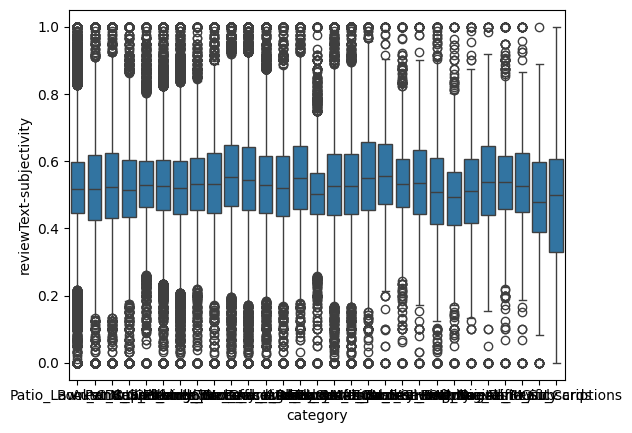

In [9]:
sns.boxplot(x='category', y='reviewText-subjectivity', data=df.toPandas())

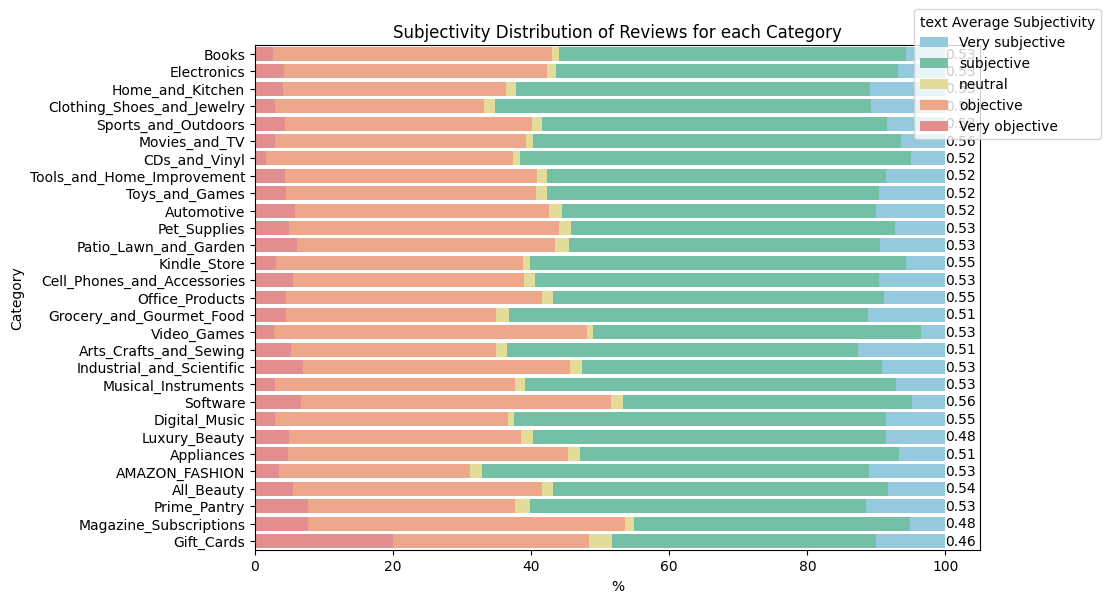

In [10]:
def plot_cat_sentiment(df, sentiments, labels):
    # Calculate comulative values
    com_df_cat_sentiment = df.toPandas().copy()
    com_df_cat_sentiment["rank"] = com_df_cat_sentiment["very_objective"] + com_df_cat_sentiment['objective']
    sentiments = ['very_objective', 'objective', 'neutral', 'subjective', 'very_subjective']
    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['rank'], ascending=False)
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(x='very_subjective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very subjective')
    sns.barplot(x='subjective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='subjective')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='neutral')
    sns.barplot(x='objective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='objective')
    sns.barplot(x='very_objective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very objective')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_subjective'], i, f'{row["average_subjectivity"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Subjectivity Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text Average Subjectivity', alignment='left')


    # Show the plot
    plt.show()

plot_cat_sentiment(df2_wide, [], [])

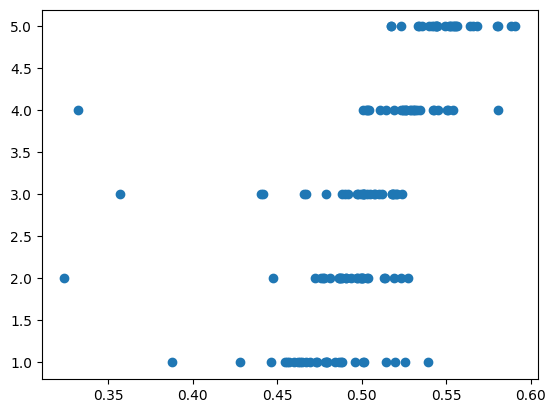

In [27]:
df_plot = df.groupBy("category", "overall").agg(avg("reviewText-subjectivity").alias("average_subjectivity")).toPandas()
# df_plot.show()
plt.scatter(x = df_plot["average_subjectivity"], y = df_plot["overall"])

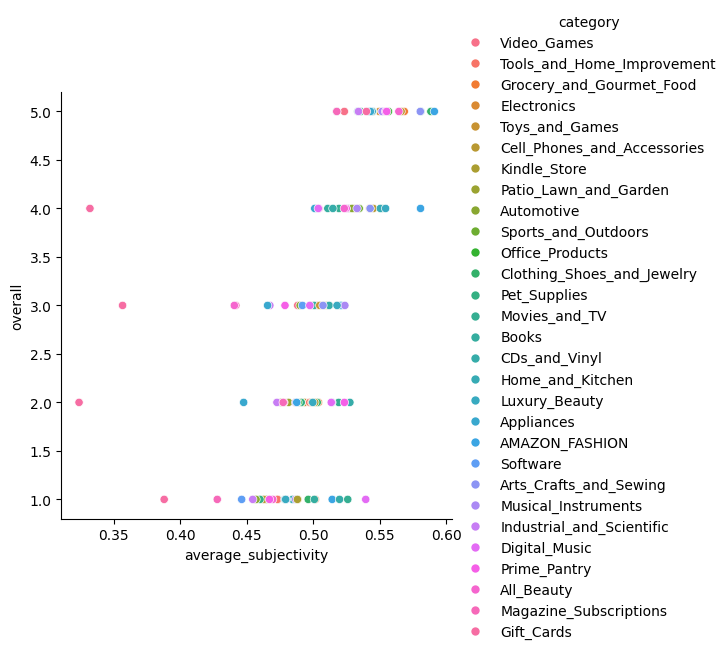

In [34]:
sns.relplot(data=df_plot, x='average_subjectivity', y='overall', hue='category')
plt.show()